In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import sys
import os
import torch
import numpy as np
import torch.nn as nn
import scipy

In [ ]:
from src.data.IBM_data_loader import generate_fluid_testing_dataset
from src.utils.utils import lp_error
from src.utils.logger import Logging
from src.utils.color import model_color
from src.utils.plot_loss import plot_loss_history
from src.utils.plotting_regular_2D import plot_time_profile_regular_data_IBM
from src.utils.plotting_regular_2D import draw_contourf_regular_2D
from src.utils.plotting_irregular_2D_interface import draw_contourf_irregular_2D

DEVICE = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "./"))

PRINT_EVERY = 1000
# file_path = "/home/vlq26735/saiful/afrah/datasets/IBM/IB_PINN3.mat"

# h=  0.498715
# k=  0.6851750000000001
# rx=  0.209685
# ry=  0.21008499999999997

In [4]:
TEST_CHECKPOINT_PATH = os.path.join(PROJECT_ROOT, "testing_checkpoints/fsi")
logger = Logging(TEST_CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()

logger.print(f"Device used {DEVICE}")

INFO:src.utils.logger:Device used cpu


### Load  and reshape the Testing Dataset if required

In [5]:
def load_data(Fluid_data, key):
    return Fluid_data[key]


DATA_FILE = "../../../data/Fluid_trainingData.mat"

TEST_DATA_PATH = "../../../data/IB_PINN3.mat"


[time_fluid, x_fluid, y_fluid, u_fluid, v_fluid, p_fluid, fx_fluid, fy_fluid] = (
    generate_fluid_testing_dataset(TEST_DATA_PATH)
)

test_torch_data = torch.tensor(
    np.concatenate([time_fluid, x_fluid, y_fluid, u_fluid, v_fluid, p_fluid], axis=1),
    dtype=torch.float32,
).to(DEVICE)


Fluid_data = scipy.io.loadmat(DATA_FILE)

interface_np = load_data(Fluid_data, "Solid_interface")

# Calculate mean and std for all columns in interface
mean_interface = interface_np.mean(axis=0, keepdims=True)[0]
std_interface = interface_np.std(axis=0, keepdims=True)[0]
mean_interface = torch.tensor(mean_interface, dtype=torch.float32).to(DEVICE)
std_interface = torch.tensor(std_interface, dtype=torch.float32).to(DEVICE)


time_interface = interface_np[:, 0].flatten()[:, None]  # test_data[0]
x_interface = interface_np[:, 1].flatten()[:, None]  # test_data[1]
y_interface = interface_np[:, 2].flatten()[:, None]  # test_data[2]
u_interface = interface_np[:, 3].flatten()[:, None]  # test_data[2]
v_interface = interface_np[:, 4].flatten()[:, None]  # test_data[2]
p_interface = interface_np[:, 5].flatten()[:, None]  # test_data[2]
fx_interface = interface_np[:, 6].flatten()[:, None]  # test_data[3]
fy_interface = interface_np[:, 7].flatten()[:, None]  # test_data[4]


time_interface_tensor = torch.tensor(time_interface, dtype=torch.float32).to(DEVICE)
x_interface_tensor = torch.tensor(x_interface, dtype=torch.float32).to(DEVICE)
y_interface_tensor = torch.tensor(y_interface, dtype=torch.float32).to(DEVICE)

# Ensure input is on the same device (GPU)
input_interface = torch.cat(
    [time_interface_tensor, x_interface_tensor, y_interface_tensor], axis=1
)

In [6]:
Bspline_MODEL_PATH = "/home/ubuntu/afrah/code/pinn_fsi_ibm/checkpoints/fsi/2024-10-20_20-58-40-587173/model.pth"

#

### Load B-spline Model

In [46]:
# Initialize models to None


model_fluid = None

# Load the state from the saved model
state = torch.load(Bspline_MODEL_PATH)
config = state.get("config", {})
loss_history = state.get("loss_history", [])
solver = config.get("solver")

for lkey, lvalue in loss_history.items():
    logger.print(f"loss: {lkey} , final loss: {lvalue[-1]:.2e}")
# Log model summary and configuration
logger.print("_summary of the model _")
logger.print("model path:", Bspline_MODEL_PATH)
logger.print("model configuration:")
for key, value in config.items():
    logger.print(f"{key} : {value}")
# Extract model configuration from state
model_activation_name = config.get("activation", "Tanh")
model_fluid_architecture = config.get("network")

# Map activation names to PyTorch activation functions

fluid_data_mean = state.get("data_mean").to("cpu")
fluid_data_std = state.get("data_std").to("cpu")


SOLVER_TO_MODULE = {
    "tanh": "src.nn.tanh",
    "xsig": "src.nn.xsigmoid",
    "bspline": "src.nn.bspline",
}

# Dynamically import the correct module and class
if solver in SOLVER_TO_MODULE:
    module = __import__(SOLVER_TO_MODULE[solver], fromlist=["PINNKAN"])
    PINNKAN = getattr(module, "PINNKAN")

    # Initialize fluid and solid models
    bspline_model_fluid = PINNKAN(model_fluid_architecture, model_activation_name).to(
        DEVICE
    )

# Plot the loss history if available

# Load the saved state dictionaries into the models
bspline_model_fluid.load_state_dict(state["model_state_dict"])

INFO:src.utils.logger:loss: left , final loss: 8.77e-01
INFO:src.utils.logger:loss: right , final loss: 4.98e-03
INFO:src.utils.logger:loss: bottom , final loss: 8.38e-04
INFO:src.utils.logger:loss: up , final loss: 8.60e-01
INFO:src.utils.logger:loss: fluid_points , final loss: 4.70e+03
INFO:src.utils.logger:loss: initial , final loss: 9.64e-04
INFO:src.utils.logger:loss: fluid , final loss: 3.84e+01
INFO:src.utils.logger:loss: vCoupling , final loss: 3.34e-02
INFO:src.utils.logger:loss: lint_pts , final loss: 3.21e+04
INFO:src.utils.logger:loss: int_initial , final loss: 3.43e+05
INFO:src.utils.logger:_summary of the model _
INFO:src.utils.logger:model path:
INFO:src.utils.logger:/home/ubuntu/afrah/code/pinn_fsi_ibm/checkpoints/fsi/2024-10-20_20-58-40-587173/model.pth
INFO:src.utils.logger:model configuration:
INFO:src.utils.logger:batch_size : 256
INFO:src.utils.logger:network : [3, 100, 100, 100, 5]
INFO:src.utils.logger:activation : xsig
INFO:src.utils.logger:solver : bspline
INFO

<All keys matched successfully>

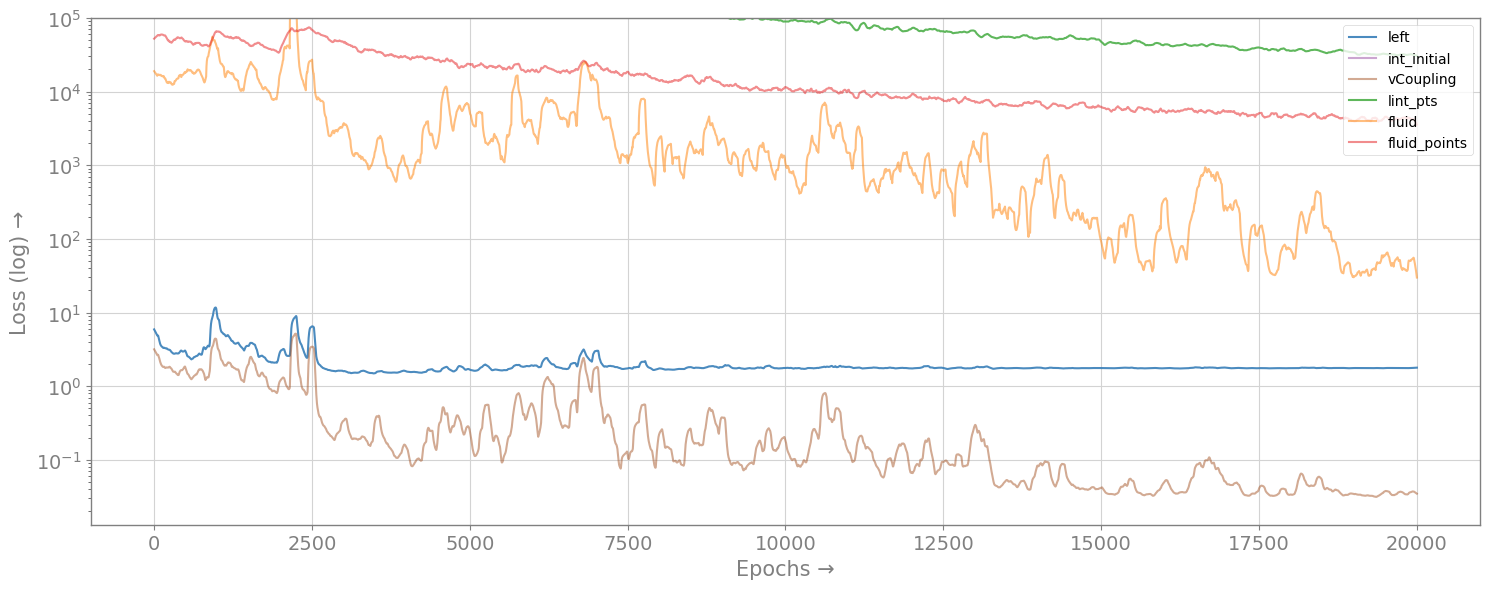

In [47]:
trim_len = 1000
bc_loss = (
    np.array(loss_history["left"][trim_len:])
    + np.array(loss_history["right"][trim_len:])
    + np.array(loss_history["bottom"][trim_len:])
    + np.array(loss_history["up"][trim_len:])
    + np.array(loss_history["initial"][trim_len:])
)

data_list = [
    {
        "data": bc_loss,
        "color": model_color["bspline"],
        "name": "left",
        "alpha": 0.9,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["int_initial"][trim_len:],
        "color": model_color["tanh"],
        "name": "int_initial",
        "alpha": 0.5,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["vCoupling"][trim_len:],
        "color": model_color["grbf"],
        "name": "vCoupling",
        "alpha": 0.5,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["lint_pts"][trim_len:],
        "color": model_color["fourier"],
        "name": "lint_pts",
        "alpha": 0.9,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["fluid"][trim_len:],
        "color": model_color["param_tanh"],
        "name": "fluid",
        "alpha": 0.5,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["fluid_points"][trim_len:],
        "color": model_color["chebyshev"],
        "name": "fluid_points",
        "alpha": 0.5,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
]


plot_loss_history(
    data_list,
    os.path.join(logger.get_output_dir(), "loss_history_fsi.png"),
    y_max=100000,
)

## Precition on the Fluid and the Solid using BSpline Model

In [48]:
with torch.no_grad():
    bspline_fluid_predictions = bspline_model_fluid.forward(
        test_torch_data[:, :3], fluid_data_mean[:3], fluid_data_std[:3]
    )
if bspline_fluid_predictions.is_cuda:
    bspline_fluid_predictions = bspline_fluid_predictions.cpu()
u_pred_fluid = bspline_fluid_predictions[:, 0:1].numpy()
v_pred_fluid = bspline_fluid_predictions[:, 1:2].numpy()
p_pred_fluid = bspline_fluid_predictions[:, 2:3].numpy()
fx_pred_fluid = bspline_fluid_predictions[:, 3:4].numpy()
fy_pred_fluid = bspline_fluid_predictions[:, 4:5].numpy()

#

text = "RelL2_"
# logger.print("\n Relative L2 ERROR:")
u_error2 = lp_error(u_pred_fluid, u_fluid, (text + "U%"), logger, 2)
v_error2 = lp_error(v_pred_fluid, v_fluid, (text + "V%"), logger, 2)
p_error2 = lp_error(p_pred_fluid, p_fluid, (text + "P%"), logger, 2)
fx_error2 = lp_error(fx_pred_fluid, fx_fluid, (text + "Fx%"), logger, 2)
fy_error2 = lp_error(fy_pred_fluid, fy_fluid, (text + "Fy%"), logger, 2)

mean_velocity = (u_error2 + v_error2) / 2
print(f"mean velocity: {mean_velocity:0.3e}")

mean_force = (fx_error2 + fy_error2) / 2
print(f"mean_force: {mean_force:0.3e}")

print(f"p_error2: {p_error2:0.3e}")

INFO:src.utils.logger:RelL2_U%  : 94.16 
INFO:src.utils.logger:RelL2_V%  : 99.88 
INFO:src.utils.logger:RelL2_P%  : 101.22 
INFO:src.utils.logger:RelL2_Fx%  : 14066.37 
INFO:src.utils.logger:RelL2_Fy%  : 11551.19 


mean velocity: 9.702e+01
mean_force: 1.281e+04
p_error2: 1.012e+02


### Prediction on the Interface using BSpline Model

In [49]:
# Forward pass through the fluid model (assuming it's already on the GPU)
with torch.no_grad():
    bspline_prediction_interface = bspline_model_fluid.forward(
        input_interface, mean_interface[:3], std_interface[:3]
    )
if bspline_prediction_interface.is_cuda:
    bspline_prediction_interface = bspline_prediction_interface.cpu()

u_pred_interface = bspline_prediction_interface[:, 0:1].numpy()
v_pred_interface = bspline_prediction_interface[:, 1:2].numpy()
p_pred_interface = bspline_prediction_interface[:, 2:3].numpy()
fx_pred_interface = bspline_prediction_interface[:, 3:4].numpy()
fy_pred_interface = bspline_prediction_interface[:, 4:5].numpy()


text = "on the interface : RelL2_"
print("on the interface")

# Calculate relative L2 errors

bspline_u_error_interface = lp_error(
    u_pred_interface, u_interface, (text + "U%"), logger, 2
)
bspline_v_error_interface = lp_error(
    v_pred_interface, v_interface, (text + "V%"), logger, 2
)
bspline_p_pred_error_interface = lp_error(
    p_pred_interface, p_interface, (text + "P%"), logger, 2
)
bspline_fx_error_interface = lp_error(
    fx_pred_interface, fx_interface, (text + "Fx%"), logger, 2
)
bspline_fy_error_interface = lp_error(
    fy_pred_interface, fy_interface, (text + "Fy%"), logger, 2
)

INFO:src.utils.logger:on the interface : RelL2_U%  : 85.61 
INFO:src.utils.logger:on the interface : RelL2_V%  : 100.15 
INFO:src.utils.logger:on the interface : RelL2_P%  : 98.26 
INFO:src.utils.logger:on the interface : RelL2_Fx%  : 46.32 
INFO:src.utils.logger:on the interface : RelL2_Fy%  : 54.89 


on the interface


### Load MLP model

In [34]:
MLP_MODEL_PATH = os.path.join(
    PROJECT_ROOT,
    "/home/ubuntu/afrah/code/pinn_fsi_ibm/checkpoints/fsi/2024-10-20_20-53-06-906457/model.pth",
)

In [50]:
# Initialize models to None


model_fluid = None

# Load the state from the saved model
state = torch.load(MLP_MODEL_PATH)
config = state.get("config", {})
loss_history = state.get("loss_history", [])
solver = config.get("solver")

for lkey, lvalue in loss_history.items():
    logger.print(f"loss: {lkey} , final loss: {lvalue[-1]:.2e}")
# Log model summary and configuration
logger.print("_summary of the model _")
logger.print("model path:", MLP_MODEL_PATH)
logger.print("model configuration:")
for key, value in config.items():
    logger.print(f"{key} : {value}")
# Extract model configuration from state
model_activation_name = config.get("activation", "Tanh")
model_fluid_architecture = config.get("network")

# Map activation names to PyTorch activation functions

fluid_data_mean = state.get("data_mean").to("cpu")
fluid_data_std = state.get("data_std").to("cpu")


SOLVER_TO_MODULE = {
    "tanh": "src.nn.tanh",
    "xsig": "src.nn.xsigmoid",
    "bspline": "src.nn.bspline",
}

# Dynamically import the correct module and class
if solver in SOLVER_TO_MODULE:
    module = __import__(SOLVER_TO_MODULE[solver], fromlist=["PINNKAN"])
    PINNKAN = getattr(module, "PINNKAN")

    # Initialize fluid and solid models
    mlp_model_fluid = PINNKAN(model_fluid_architecture, model_activation_name).to(
        DEVICE
    )

# Plot the loss history if available

# Load the saved state dictionaries into the models
mlp_model_fluid.load_state_dict(state["model_state_dict"])

INFO:src.utils.logger:loss: left , final loss: 3.22e-01
INFO:src.utils.logger:loss: right , final loss: 3.41e-02
INFO:src.utils.logger:loss: bottom , final loss: 6.38e-03
INFO:src.utils.logger:loss: up , final loss: 2.64e-01
INFO:src.utils.logger:loss: fluid_points , final loss: 2.12e+04
INFO:src.utils.logger:loss: initial , final loss: 1.14e-02
INFO:src.utils.logger:loss: fluid , final loss: 5.19e+00
INFO:src.utils.logger:loss: vCoupling , final loss: 3.07e-02
INFO:src.utils.logger:loss: lint_pts , final loss: 2.19e+05
INFO:src.utils.logger:loss: int_initial , final loss: 4.17e+05
INFO:src.utils.logger:_summary of the model _
INFO:src.utils.logger:model path:
INFO:src.utils.logger:/home/ubuntu/afrah/code/pinn_fsi_ibm/checkpoints/fsi/2024-10-20_20-53-06-906457/model.pth
INFO:src.utils.logger:model configuration:
INFO:src.utils.logger:batch_size : 256
INFO:src.utils.logger:network : [3, 350, 350, 350, 5]
INFO:src.utils.logger:activation : xsig
INFO:src.utils.logger:solver : xsig
INFO:sr

<All keys matched successfully>

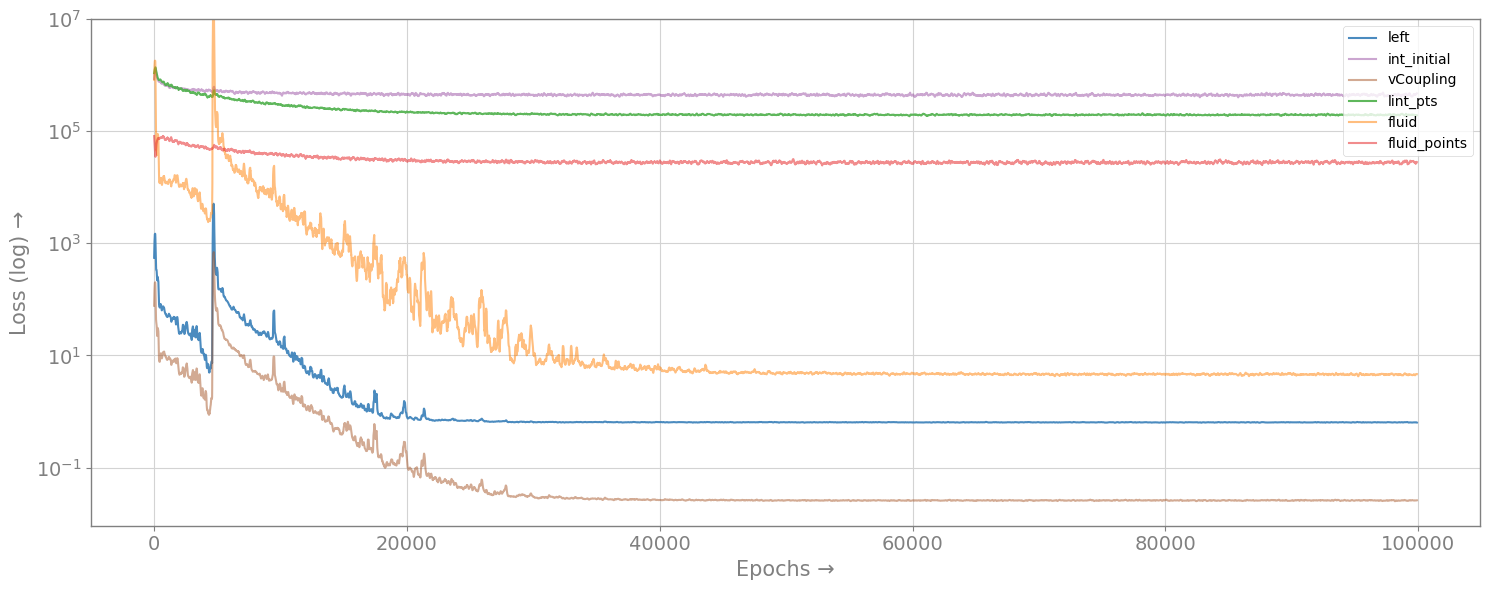

In [51]:
trim_len = 100
bc_loss = (
    np.array(loss_history["left"][trim_len:])
    + np.array(loss_history["right"][trim_len:])
    + np.array(loss_history["bottom"][trim_len:])
    + np.array(loss_history["up"][trim_len:])
    + np.array(loss_history["initial"][trim_len:])
)

data_list = [
    {
        "data": bc_loss,
        "color": model_color["bspline"],
        "name": "left",
        "alpha": 0.9,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["int_initial"][trim_len:],
        "color": model_color["tanh"],
        "name": "int_initial",
        "alpha": 0.5,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["vCoupling"][trim_len:],
        "color": model_color["grbf"],
        "name": "vCoupling",
        "alpha": 0.5,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["lint_pts"][trim_len:],
        "color": model_color["fourier"],
        "name": "lint_pts",
        "alpha": 0.9,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["fluid"][trim_len:],
        "color": model_color["param_tanh"],
        "name": "fluid",
        "alpha": 0.5,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["fluid_points"][trim_len:],
        "color": model_color["chebyshev"],
        "name": "fluid_points",
        "alpha": 0.5,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
]


plot_loss_history(
    data_list,
    os.path.join(logger.get_output_dir(), "loss_history_fsi.png"),
    y_max=10000000,
)

In [37]:
with torch.no_grad():
    mlp_prediction_fluid = mlp_model_fluid.forward(
        test_torch_data[:, :3], fluid_data_mean[:3], fluid_data_std[:3]
    )


if mlp_prediction_fluid.is_cuda:
    mlp_prediction_fluid = mlp_prediction_fluid.cpu()
u_pred_fluid = mlp_prediction_fluid[:, 0:1].numpy()
v_pred_fluid = mlp_prediction_fluid[:, 1:2].numpy()
p_pred_fluid = mlp_prediction_fluid[:, 2:3].numpy()
fx_pred_fluid = mlp_prediction_fluid[:, 3:4].numpy()
fy_pred_fluid = mlp_prediction_fluid[:, 4:5].numpy()

#

text = "RelL2_"
# logger.print("\n Relative L2 ERROR:")
u_error2 = lp_error(u_pred_fluid, u_fluid, (text + "U%"), logger, 2)
v_error2 = lp_error(v_pred_fluid, v_fluid, (text + "V%"), logger, 2)
p_error2 = lp_error(p_pred_fluid, p_fluid, (text + "P%"), logger, 2)
fx_error2 = lp_error(fx_pred_fluid, fx_fluid, (text + "Fx%"), logger, 2)
fy_error2 = lp_error(fy_pred_fluid, fy_fluid, (text + "Fy%"), logger, 2)


mean_velocity = (u_error2 + v_error2) / 2
print(f"mean velocity: {mean_velocity:0.3e}")

mean_force = (fx_error2 + fy_error2) / 2
print(f"mean_force: {mean_force:0.3e}")

print(f"p_error2: {p_error2:0.3e}")

INFO:src.utils.logger:RelL2_U%  : 79.62 
INFO:src.utils.logger:RelL2_V%  : 69.74 
INFO:src.utils.logger:RelL2_P%  : 83.21 
INFO:src.utils.logger:RelL2_Fx%  : 15606.49 
INFO:src.utils.logger:RelL2_Fy%  : 12022.17 


mean velocity: 7.468e+01
mean_force: 1.381e+04
p_error2: 8.321e+01


### Prediction on the Interface using MLP model

In [38]:
# Forward pass through the fluid model (assuming it's already on the GPU)
with torch.no_grad():
    mlp_prediction_interface = mlp_model_fluid.forward(
        input_interface, mean_interface[:3], std_interface[:3]
    )
if mlp_prediction_interface.is_cuda:
    mlp_prediction_interface = mlp_prediction_interface.cpu()
u_pred_interface = mlp_prediction_interface[:, 0:1].numpy()
v_pred_interface = mlp_prediction_interface[:, 1:2].numpy()
p_pred_interface = mlp_prediction_interface[:, 2:3].numpy()
fx_pred_interface = mlp_prediction_interface[:, 3:4].numpy()
fy_pred_interface = mlp_prediction_interface[:, 4:5].numpy()


text = "on the interface : RelL2_"
print("on the interface")

# Calculate relative L2 errors

u_error_interface = lp_error(u_pred_interface, u_interface, (text + "U%"), logger, 2)
v_error_interface = lp_error(v_pred_interface, v_interface, (text + "V%"), logger, 2)
p_pred_error_interface = lp_error(
    p_pred_interface, p_interface, (text + "P%"), logger, 2
)
fx_error_interface = lp_error(
    fx_pred_interface, fx_interface, (text + "Fx%"), logger, 2
)
fy_error_interface = lp_error(
    fy_pred_interface, fy_interface, (text + "Fy%"), logger, 2
)

INFO:src.utils.logger:on the interface : RelL2_U%  : 112.78 
INFO:src.utils.logger:on the interface : RelL2_V%  : 51.17 
INFO:src.utils.logger:on the interface : RelL2_P%  : 61.09 
INFO:src.utils.logger:on the interface : RelL2_Fx%  : 52.96 
INFO:src.utils.logger:on the interface : RelL2_Fy%  : 61.01 


on the interface


### Combine the precitions of MLP and BSpline if required

In [44]:
combine_fluid = True
if combine_fluid:
    fluid_predictions = (mlp_prediction_fluid + bspline_fluid_predictions) / 2

    u_pred_fluid = fluid_predictions[:, 0:1].numpy()
    v_pred_fluid = fluid_predictions[:, 1:2].numpy()
    p_pred_fluid = fluid_predictions[:, 2:3].numpy()
    fx_pred_fluid = fluid_predictions[:, 3:4].numpy()
    fy_pred_fluid = fluid_predictions[:, 4:5].numpy()

    text = "Fluid RelL2_"
    # logger.print("\n Relative L2 ERROR:")
    u_error2 = lp_error(u_pred_fluid, u_fluid, (text + "U%"), logger, 2)
    v_error2 = lp_error(v_pred_fluid, v_fluid, (text + "V%"), logger, 2)
    p_error2 = lp_error(p_pred_fluid, p_fluid, (text + "P%"), logger, 2)
    fx_error2 = lp_error(fx_pred_fluid, fx_fluid, (text + "Fx%"), logger, 2)
    fy_error2 = lp_error(fy_pred_fluid, fy_fluid, (text + "Fy%"), logger, 2)

    mean_velocity = (u_error2 + v_error2) / 2
    print(f"mean velocity: {mean_velocity:0.3e}")

    mean_force = (fx_error2 + fy_error2) / 2
    print(f"mean_force: {mean_force:0.3e}")

    print(f"p_error2: {p_error2:0.3e}")


combine_interface = True
if combine_fluid:
    interface_predictions = (
        mlp_prediction_interface + bspline_prediction_interface
    ) / 2

    u_pred_interface = interface_predictions[:, 0:1].numpy()
    v_pred_interface = interface_predictions[:, 1:2].numpy()
    p_pred_interface = interface_predictions[:, 2:3].numpy()
    fx_pred_interface = interface_predictions[:, 3:4].numpy()
    fy_pred_interface = interface_predictions[:, 4:5].numpy()
    text = "Interface : RelL2_"

    # Calculate relative L2 errors

    u_error_interface = lp_error(
        u_pred_interface, u_interface, (text + "U%"), logger, 2
    )
    v_error_interface = lp_error(
        v_pred_interface, v_interface, (text + "V%"), logger, 2
    )
    p_pred_error_interface = lp_error(
        p_pred_interface, p_interface, (text + "P%"), logger, 2
    )
    fx_error_interface = lp_error(
        fx_pred_interface, fx_interface, (text + "Fx%"), logger, 2
    )
    fy_error_interface = lp_error(
        fy_pred_interface, fy_interface, (text + "Fy%"), logger, 2
    )

INFO:src.utils.logger:Fluid RelL2_U%  : 95.03 
INFO:src.utils.logger:Fluid RelL2_V%  : 96.75 
INFO:src.utils.logger:Fluid RelL2_P%  : 109.59 
INFO:src.utils.logger:Fluid RelL2_Fx%  : 11426.86 
INFO:src.utils.logger:Fluid RelL2_Fy%  : 8373.14 
INFO:src.utils.logger:Interface : RelL2_U%  : 262.16 
INFO:src.utils.logger:Interface : RelL2_V%  : 127.74 
INFO:src.utils.logger:Interface : RelL2_P%  : 144.12 
INFO:src.utils.logger:Interface : RelL2_Fx%  : 50.45 
INFO:src.utils.logger:Interface : RelL2_Fy%  : 58.47 


mean velocity: 9.589e+01
mean_force: 9.900e+03
p_error2: 1.096e+02


In [ ]:
### Draw the solid and the fluid prediction

In [45]:
tstep = 101
xstep = 102
ystep = 102
part = "Fluid"
N_data = xstep * ystep

steps = [tstep, xstep, ystep]
txy = [x_fluid, y_fluid, time_fluid]

plot_time_profile_regular_data_IBM(
    logger.get_output_dir(), steps, txy, u_fluid, u_pred_fluid, "$u$"
)
plot_time_profile_regular_data_IBM(
    logger.get_output_dir(), steps, txy, v_fluid, v_pred_fluid, "$v$"
)
plot_time_profile_regular_data_IBM(
    logger.get_output_dir(), steps, txy, p_fluid, p_pred_fluid, "$p$"
)
plot_time_profile_regular_data_IBM(
    logger.get_output_dir(), steps, txy, fx_fluid, fx_pred_fluid, "_$Fx$_"
)
plot_time_profile_regular_data_IBM(
    logger.get_output_dir(), steps, txy, fy_fluid, fy_pred_fluid, "_$Fy$_"
)


#  t = tf.reshape(tstep,N_data)[:,0].T
tf100 = time_fluid.reshape(tstep, xstep, ystep)[:, 0, 0]
fluid_x = x_fluid.reshape(tstep, xstep, ystep)[0, :, 0]  # .reshape(100,100)[0,:]
fluid_y = y_fluid.reshape(tstep, xstep, ystep)[0, 0, :]  # .reshape(100,100)[:,0]

u_fluid_cfd_reshape = u_fluid.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
v_fluid_cfd_reshape = v_fluid.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
p_fluid_cfd_reshape = p_fluid.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
fx_fluid_cfd_reshape = fx_fluid.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
fy_fluid_cfd_reshape = fy_fluid.reshape(tstep, xstep, ystep).transpose((0, 2, 1))

u_fluid_pred_reshape = u_pred_fluid.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
v_fluid_pred_reshape = v_pred_fluid.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
p_fluid_pred_reshape = p_pred_fluid.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
fx_fluid_pred_reshape = fx_pred_fluid.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
fy_fluid_pred_reshape = fy_pred_fluid.reshape(tstep, xstep, ystep).transpose((0, 2, 1))

u_error_fluid = np.abs(u_fluid_cfd_reshape - u_fluid_pred_reshape)
v_error_fluid = np.abs(v_fluid_cfd_reshape - v_fluid_pred_reshape)
p_error_fluid = np.abs(p_fluid_cfd_reshape - p_fluid_pred_reshape)
fx_error_fluid = np.abs(fx_fluid_cfd_reshape - fx_fluid_pred_reshape)
fy_error_fluid = np.abs(fy_fluid_cfd_reshape - fy_fluid_pred_reshape)

fluid_data = [
    u_fluid_pred_reshape,
    v_fluid_pred_reshape,
    p_fluid_pred_reshape,
    fx_fluid_pred_reshape,
    fy_fluid_pred_reshape,
    u_fluid_cfd_reshape,
    v_fluid_cfd_reshape,
    p_fluid_cfd_reshape,
    fx_fluid_cfd_reshape,
    fy_fluid_cfd_reshape,
    u_error_fluid,
    v_error_fluid,
    p_error_fluid,
    fx_error_fluid,
    fy_error_fluid,
]

nrows_ncols = (3, 5)
time_values = [99, 90, 70, 50, 20, 0]
titles = [
    "u_pinn",
    "v_pinn",
    "p_pinn",
    "fx_pinn",
    "fy_pinn",
    "u_cfd",
    "v_cfd",
    "p_cfd",
    "fx_cfd",
    "fy_cfd",
    "error_u",
    "error_v",
    "error_p",
    "error_fx",
    "error_fy",
]

draw_contourf_regular_2D(
    tf100,
    fluid_x,
    fluid_y,
    fluid_data,
    titles,
    nrows_ncols,
    time_values,
    1.0,
    1.0,
    model_dirname,
    15,
    12,
    5,
    fontsize=9.5,
    labelsize=9.5,
    axes_pad=1.0,
)

### Draw Interface Data

In [40]:
tstep = 101
N_data = int(time_interface.shape[0] / tstep)

#  t = tf.reshape(tstep,N_data)[:,0].T
tf100 = time_interface.reshape(tstep, N_data)[:, 0].T
interface_x = x_interface.reshape(tstep, N_data)[0, :]
interface_y = y_interface.reshape(tstep, N_data)[0, :]

u_interface_reshape = u_interface.reshape(tstep, N_data)
v_interface_reshape = v_interface.reshape(tstep, N_data)
p_interface_reshape = p_interface.reshape(tstep, N_data)
fx_interface_reshape = fx_interface.reshape(tstep, N_data)
fy_interface_reshape = fy_interface.reshape(tstep, N_data)


u_pred_interface_reshape = u_pred_interface.reshape(tstep, N_data)
v_pred_interface_reshape = v_pred_interface.reshape(tstep, N_data)
p_pred_interface_reshape = p_pred_interface.reshape(tstep, N_data)
fx_pred_interface_reshape = fx_pred_interface.reshape(tstep, N_data)
fy_pred_interface_reshape = fy_pred_interface.reshape(tstep, N_data)

u_error_interface = np.abs(u_interface_reshape - u_pred_interface_reshape)
v_error_interface = np.abs(v_interface_reshape - v_pred_interface_reshape)
p_error_interface = np.abs(p_interface_reshape - p_pred_interface_reshape)
fx_error_interface = np.abs(fx_interface_reshape - fx_pred_interface_reshape)
fy_error_interface = np.abs(fy_interface_reshape - fy_pred_interface_reshape)

nrows_ncols = (3, 5)
time_values = [0, 50, 99]
interface_data = [
    u_pred_interface_reshape,
    v_pred_interface_reshape,
    p_pred_interface_reshape,
    fx_pred_interface_reshape,
    fy_pred_interface_reshape,
    u_interface_reshape,
    v_interface_reshape,
    p_interface_reshape,
    fx_interface_reshape,
    fy_interface_reshape,
    u_error_interface,
    v_error_interface,
    p_error_interface,
    fx_error_interface,
    fy_error_interface,
]

titles = [
    "u_pinn",
    "v_pinn",
    "p_pinn",
    "fx_pinn",
    "fy_pinn",
    "u_cfd",
    "v_cfd",
    "p_cfd",
    "fx_cfd",
    "fy_cfd",
    "u_error",
    "v_error",
    "p_error",
    "fx_error",
    "fy_error",
]

fig_size = (25, 25)
draw_contourf_irregular_2D(
    tf100,
    interface_x,
    interface_y,
    interface_data,
    titles,
    model_dirname,
    nrows_ncols,
    time_values,
    ticks=5,
    fontsize=10.5,
    labelsize=7,
    axes_pad=1,
)